In [2]:
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit # Numerically stable sigmoid function
from scipy.optimize import curve_fit

# Import Data

# Set print options to suppress scientific notation
np.set_printoptions(suppress=True)

year = 2014
period = ['may-jun', 'jun-jul']

# Import data
if year == 2014:
    X = np.load('../data/processed/data_2014.npz')

elif year == 2015:
    X = np.load('../data/processed/data_2015.npz')

elif year == 2016:
    X = np.load('../data/processed/data_2016.npz')
    
elif year == 2017:
    X = np.load('../data/processed/data_2017.npz')

N = X['N']

distance = X['distance']
dist = X['distance']
#tI1 = X['tI1'].reshape(N,1)
#tI2 = X['tI2'].reshape(N,1)
sI2 = X['sI2'].reshape(N,1)

y_apr = X['y_apr'].reshape(N,1)
y_may = X['y_may'].reshape(N,1)
y_jun = X['y_jun'].reshape(N,1)
y_jul = X['y_jul'].reshape(N,1)

n_apr = X['n_apr'].reshape(N,1)
n_may = X['n_may'].reshape(N,1)
n_jun = X['n_jun'].reshape(N,1)
n_jul = X['n_jul'].reshape(N,1)

area_apr = X['a_apr'].reshape(N,1)
a_apr = X['a_apr'].reshape(N,1)
a_may = X['a_may'].reshape(N,1)
a_jun = X['a_jun'].reshape(N,1)
a_jul = X['a_jul'].reshape(N,1)

w_apr = X['wind_apr']
w_may = X['wind_may']
w_jun = X['wind_jun']
w_jul = X['wind_jul']

sI1_apr = X['sI1_apr'].reshape(N,1)
sI1_may = X['sI1_may'].reshape(N,1)
sI1_jun = X['sI1_jun'].reshape(N,1)
sI1_jul = X['sI1_jul'].reshape(N,1)

s_apr = X['s_apr'].reshape(N,1)
s_may = X['s_may'].reshape(N,1)
s_jun = X['s_jun'].reshape(N,1)
s_jul = X['s_jul'].reshape(N,1)

# Convert to float64
dist = dist.astype(np.float64)
#tI1 = tI1.astype(np.float64)
#tI2 = tI2.astype(np.float64)
sI2 = sI2.astype(np.float64)

y_apr = y_apr.astype(np.float64)
y_may = y_may.astype(np.float64)
y_jun = y_jun.astype(np.float64)
y_jul = y_jul.astype(np.float64)

n_apr = n_apr.astype(np.float64)
n_may = n_may.astype(np.float64)
n_jun = n_jun.astype(np.float64)
n_jul = n_jul.astype(np.float64)

a_apr = a_apr.astype(np.float64)
a_may = a_may.astype(np.float64)
a_jun = a_jun.astype(np.float64)
a_jul = a_jul.astype(np.float64)

w_apr = w_apr.astype(np.float64)
w_may = w_may.astype(np.float64)
w_jun = w_jun.astype(np.float64)
w_jul = w_jul.astype(np.float64)

sI1_apr = sI1_apr.astype(np.float64)
sI1_may = sI1_may.astype(np.float64)
sI1_jun = sI1_jun.astype(np.float64)
sI1_jul = sI1_jul.astype(np.float64)

s_apr = s_apr.astype(np.float64)
s_may = s_may.astype(np.float64)
s_jun = s_jun.astype(np.float64)
s_jul = s_jul.astype(np.float64)

area_hectares = a_apr

# Function to normalize the data
def norm(x):
    
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Normalize the data
dist = norm(dist)

a_apr = norm(a_apr)
a_may = norm(a_may)
a_jun = norm(a_jun)
a_jul = norm(a_jul)


# Import Paramaters

if year == 2014:
    
    theta_may_jun = np.load('../reports/parameters/theta_may-jun_2014_SLSQP.npy', allow_pickle=True)
    theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_2014_SLSQP.npy', allow_pickle=True)
    
elif year == 2015:
    
    theta_may_jun = np.load('../reports/parameters/theta_may-jun_2015.npy', allow_pickle=True)
    theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_2015.npy', allow_pickle=True)
    
elif year == 2016:
    
    theta_may_jun = np.load('../reports/parameters/theta_may-jun_2016.npy', allow_pickle=True)
    theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_2016.npy', allow_pickle=True)
    
elif year == 2017:
    
    theta_may_jun = np.load('../reports/parameters/theta_may-jun_2017_1_1.npy', allow_pickle=True)
    theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_2017_1_1.npy', allow_pickle=True)

# Safe exponential function
def safe_exp(x):
    """Prevent overflow of exponential function."""
    # np.finfo('d').max is the maximum representable positive number
    # np.log(np.finfo('d').max) is the maximum number that can be exponentiated without overflow
    # We clamp x to this range before taking the exponent
    x = np.clip(x, None, np.log(np.finfo('d').max))
    return np.exp(x)

# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period

def eta(period, y_lag, sprays):
    
    y_lag = y_lag
    
    if period == 'may-jun':
        theta = theta_may_jun
        #y_lag = y_may
        n_lag = n_may
        a_lag = a_may
        w_lag = w_may
        #sI1_lag = sI1_may
        s_lag = sprays # need to fix this to be a conditional function

    elif period == 'jun-jul':
        theta = theta_jun_jul
        #y_lag = y_jun
        n_lag = n_jun
        a_lag = a_jun
        w_lag = w_jun
        #sI1_lag = sI1_jun
        s_lag = predict_sprays(period, sprays)
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    beta1_array = np.full((N,1), beta1)
    beta2_array = np.full((N,1), beta2)
    
    auto_infection1 = delta1 * (y_lag / n_lag) * np.exp(-eta11 * s_lag)
    auto_infection2 = delta2 * (y_lag / n_lag) * np.exp(-eta12 * s_lag)
    
    dispersal1 = []
    dispersal2 = []
    
    eta_1 = [] 
    
    for i in range(0, N):
        
        dispersal_array = ((a_lag * (y_lag / n_lag)) * (w_lag[:, i].reshape(N,1)))
        dispersal_array1 = dispersal_array * np.exp(-eta21 * s_lag) * np.exp(-alpha1 * dist[:, i].reshape(N,1)) * sI1_lag
        dispersal_array2 = dispersal_array * np.exp(-eta22 * s_lag) * np.exp(-alpha2 * dist[:, i].reshape(N,1)) * sI2
        dispersal_component1_i = gamma1 * (np.sum(dispersal_array1) - dispersal_array1[i][0])
        dispersal_component2_i = gamma2 * (np.sum(dispersal_array2) - dispersal_array2[i][0])
        
        dispersal1.append(dispersal_component1_i)
        dispersal2.append(dispersal_component2_i)
    
    dispersal1 = np.array(dispersal1).reshape(N,1)
    dispersal2 = np.array(dispersal2).reshape(N,1)
    
    eta = tI1 * (beta1_array + auto_infection1 + dispersal1) + tI2 * (beta2_array + auto_infection2 + dispersal2)
    
    eta_1_i = tI1[i] * (auto_infection1 + dispersal1) + tI2[i] * (auto_infection2 + dispersal2)
    eta_1.append(eta_1_i)
    eta_1 = np.array(eta_1).reshape(N,1)
    
    return eta, eta_1


# Probability Function

def prob(period, y_lag, sprays):
    
    etaa = eta(period, y_lag, sprays)
    
    p = expit(etaa[0])
    
    for i in range(0, N):
    
        if etaa[1][i] == 0.0:
            
            p[i] = 0.0    
    
    return p

# Read data from CSV file into a pandas DataFrame
df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')

# Revenue Function

In [3]:
# Data for the estimation of cone incidence vs leaf incidence
df_cone_incidence_leaf_incidence = pd.read_csv('../data/raw/economics/Leaf incidence_vs_Cone_incidence.csv', encoding='utf-8')

# Data preprocessing
df_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.dropna()

# Data for the estimation of yield loss vs cone incidence (change in quantity metric)
df_yield_loss_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
df_yield_loss_cone_incidence = df_yield_loss_cone_incidence[['Cone incidence', 'Yield Loss']]

# Data for the estimation of cone color vs cone incidence (change in quality metric)
df_cone_color_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
df_cone_color_cone_incidence = df_cone_color_cone_incidence[['Cone incidence', 'Cone Color']]


# Data
data_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.to_numpy()
data_yield_loss_cone_incidence = df_yield_loss_cone_incidence.to_numpy()
data_cone_color_cone_incidence = df_cone_color_cone_incidence.to_numpy()

# Regressions

# CONE INCIDENCE VS LEAF INCIDENCE
a1, b1 = np.polyfit(data_cone_incidence_leaf_incidence[:, 0], data_cone_incidence_leaf_incidence[:, 1], 1)

# YIELD LOSS VS CONE INCIDENCE
a2, b2 = np.polyfit(data_yield_loss_cone_incidence[:, 0], data_yield_loss_cone_incidence[:, 1], 1)

# CONE COLOR VS CONE INCIDENCE
# Define the exponential decay function that passes through (0, 10)
def exp_decreasing(x, a3, b3):
    return 10 + a3 * (1 - np.exp(-b3 * x))

# Provide an initial guess for the parameters
initial_guess = [1, 1]

# Fit the exponential decay model to the data, with an increased max number of function evaluations
params, _ = curve_fit(exp_decreasing, data_cone_color_cone_incidence[:, 0], data_cone_color_cone_incidence[:, 1], p0=initial_guess, maxfev=5000)

a3, b3 = params


# Load parameters
checkpoint1 = np.load('../reports/checkpoint_high_demand.npy', allow_pickle=True)
theta_high = checkpoint1[0]

checkpoint2 = np.load('../reports/checkpoint_moderate_demand.npy', allow_pickle=True)
theta_moderate = checkpoint2[0]

checkpoint3 = np.load('../reports/checkpoint_low_demand.npy', allow_pickle=True)
theta_low = checkpoint3[0]

# Define logistic sigmoid function
def sigmoid(z):

    g = 1 / (1 + np.exp(-z))
    
    return g

# QUALITY METRIC
# Function to estimate cone color given plant incidence
def cone_color(plant_incidence, n=100, D=1.19):
    
    # n is the number of leaves sampled and D is the index of dispersion
    n_D = n / D 
    
    leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)
    
    cone_incidence = a1 * leaf_incidence + b1
    
    # intercept fixed at 10 since that's the highest cone color rating
    cone_color = 10 + a3 * (1 - np.exp(-b3 * cone_incidence))
    
    return cone_color

# QUANTITY METRIC
# Function to estimate yield loss given plant incidence (probability of disease in plants)
def yield_loss(plant_incidence, n=100, D=1.19):
    
    # n is the number of leaves sampled and D is the index of dispersion
    n_D = n / D 
    
    leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)
    
    cone_incidence = a1 * leaf_incidence + b1
    
    yield_loss = a2 * cone_incidence
    
    return yield_loss


# Function to estimate revenue and revenue change given plant incidence
def revenue(plant_incidence, variety, demand, n=100, D=1.19):
    
    # Define the data for different varieties
    varieties_data = {
        "nugget": {"initial_yield": 2038.0, "initial_price": [2.5, 4.25, 6.0]},
        "chinook": {"initial_yield": 1629.3333, "initial_price": [4.0, 5.0, 6.5]},
        "simcoe": {"initial_yield": 1752.0, "initial_price": [5.0, 6.5, 8.0]},
        "mosaic": {"initial_yield": 2134.0, "initial_price": [5.0, 6.5, 8.0]},
    }
    
    demand_to_idx = {
    "low": 0,
    "moderate": 1,
    "high": 2
    }
    
    theta_values = {
        "low": theta_low,
        "moderate": theta_moderate,
        "high": theta_high
    }
    
    # Convert the demand to theta values
    theta_demand = theta_values[demand]
    
    # Extract initial values based on variety
    initial_yields = np.array([varieties_data[var[0]]["initial_yield"] for var in variety])
    initial_prices = np.array([varieties_data[var[0]]["initial_price"][demand_to_idx[demand]] for var in variety])

    # Calculate adjusted yields and prices
    adjusted_yields = initial_yields * (1 - yield_loss(plant_incidence, n, D).squeeze())
    adjusted_prices = initial_prices * sigmoid(theta_demand[0] + theta_demand[1] * cone_color(plant_incidence, n, D).squeeze())
    
    # Calculate the adjusted revenue
    adjusted_revenues = adjusted_prices * adjusted_yields

    return adjusted_revenues.reshape(-1, 1)

## Synthetic Spray Data

### Poisson regression

In [3]:
import pandas as pd
import statsmodels.api as sm

# MAY-JUNE
# Define the dependent (response) variable and the independent (predictor) variable
X_may = df[(df['Month'] == 'May')]['Mildew Incidence'].reset_index(drop=True)
y_jun = df[(df['Month'] == 'June')]['Sprays'].reset_index(drop=True)

# Add a constant to the predictor variables (it's a best practice)
X_may = sm.add_constant(X_may)

# Fit the Poisson regression model
pois_may_jun = sm.GLM(y_jun, X_may, family=sm.families.Poisson()).fit()


# JUNE-JULY
# Define the dependent (response) variable and the independent (predictor) variable
X_jun = df[(df['Month'] == 'June')]['Mildew Incidence'].reset_index(drop=True)
y_jul = df[(df['Month'] == 'July')]['Sprays'].reset_index(drop=True)

# Add a constant to the predictor variables (it's a best practice)
X_jun = sm.add_constant(X_jun)

# Fit the Poisson regression model
pois_jun_jul = sm.GLM(y_jul, X_jun, family=sm.families.Poisson()).fit()


# Print the summary of the regression
#print(model.summary())

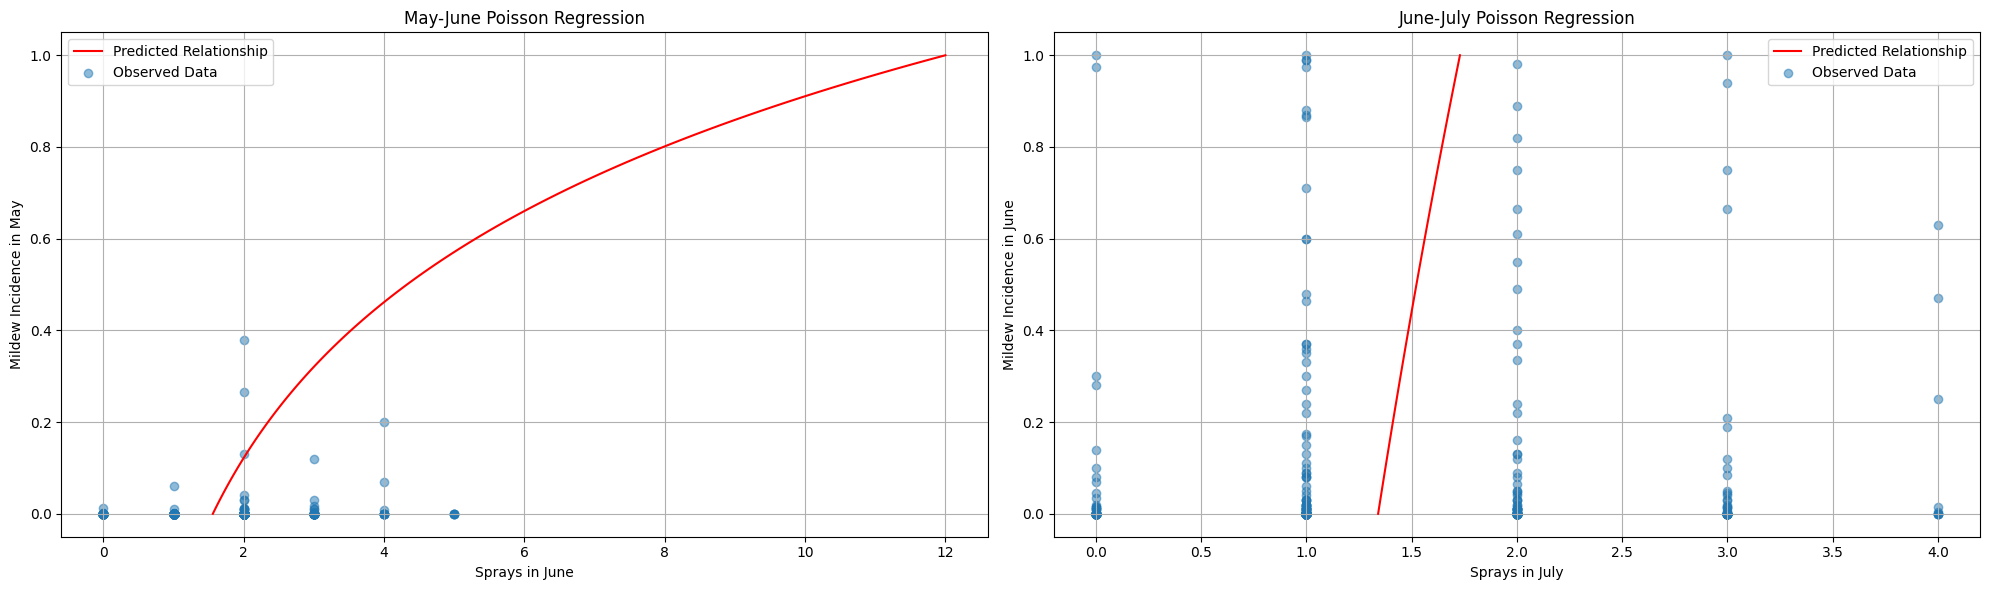

In [4]:
# Generate a range of mildew incidence values
mildew_range = np.linspace(0, 1, 100)

# Create a DataFrame with these values and a constant
predict_df = pd.DataFrame({'Mildew Incidence': mildew_range})
predict_df = sm.add_constant(predict_df)

# Predict the number of sprays for May-June and June-July
predicted_sprays_may_jun = pois_may_jun.predict(predict_df)
predicted_sprays_jun_jul = pois_jun_jul.predict(predict_df)

# Create a figure and a 1x2 grid of subplots
plt.figure(figsize=(20, 6))

# May-June Poisson Regression
plt.subplot(1, 2, 1)
plt.plot(predicted_sprays_may_jun, mildew_range, '-r', label='Predicted Relationship')
plt.scatter(y_jun, X_may['Mildew Incidence'], alpha=0.5, label='Observed Data')
plt.ylabel('Mildew Incidence in May')
plt.xlabel('Sprays in June')
plt.legend()
plt.title('May-June Poisson Regression')
plt.grid(True)

# June-July Poisson Regression
plt.subplot(1, 2, 2)
plt.plot(predicted_sprays_jun_jul, mildew_range, '-r', label='Predicted Relationship')
plt.scatter(y_jul, X_jun['Mildew Incidence'], alpha=0.5, label='Observed Data')
plt.ylabel('Mildew Incidence in June')
plt.xlabel('Sprays in July')
plt.legend()
plt.title('June-July Poisson Regression')
plt.grid(True)

plt.tight_layout()
plt.show()

### Function for predicting sprays given mildew incidence

In [5]:
# Function to predict number of sprays in a given period using the period before
def predict_sprays(period, mildew_values):
    
    if period == 'may-jun':
        # Flatten the input and convert to DataFrame
        mildew_values = np.array(mildew_values).flatten()
        input_df = pd.DataFrame({'Mildew Incidence': mildew_values})
        input_df = sm.add_constant(input_df, has_constant='add')
        
        # Predict the number of sprays using the pois_may_jun model
        predicted_sprays = pois_may_jun.predict(input_df)
        predicted_sprays = predicted_sprays.values
        predicted_sprays = predicted_sprays.reshape(-1, 1)
        
    elif period == 'jun-jul':
        # Flatten the input and convert to DataFrame
        mildew_values = np.array(mildew_values).flatten()
        input_df = pd.DataFrame({'Mildew Incidence': mildew_values})
        input_df = sm.add_constant(input_df, has_constant='add')
        
        # Predict the number of sprays using the pois_may_jun model
        predicted_sprays = pois_jun_jul.predict(input_df)
        predicted_sprays = predicted_sprays.values
        predicted_sprays = predicted_sprays.reshape(-1, 1)
    
    return predicted_sprays

### Mean sprays per month

In [6]:
# Mean sprays per month when mildew incidence is 0
lambda_may_0 = df[((df['Month'] == 'May') & (df['Mildew Incidence'] == 0))]['Sprays'].mean()
lambda_jun_0 = df[((df['Month'] == 'June') & (df['Mildew Incidence'] == 0))]['Sprays'].mean()
lambda_jul_0 = df[((df['Month'] == 'July') & (df['Mildew Incidence'] == 0))]['Sprays'].mean()

# Mean sprays per month when mildew incidence is > 0
lambda_may = df[((df['Month'] == 'May') & (df['Mildew Incidence'] > 0))]['Sprays'].mean()
lambda_jun = df[((df['Month'] == 'June') & (df['Mildew Incidence'] > 0))]['Sprays'].mean()
lambda_jul = df[((df['Month'] == 'July') & (df['Mildew Incidence'] > 0))]['Sprays'].mean()

# Cost Function

In [8]:
# Read data from CSV file into a pandas DataFrame
df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')

# Application cost of fungicide sprays adjusted for inflation

fung_application_cost = 16.0 #need to adjust for inflation

# Convert application costs from dollars per acre to dollars per hectare
fung_application_cost = fung_application_cost * 2.471053814671653

# PPI (Jan 2022 base) for 2014-2020
ppi = [89.63222295, 78.91586143, 71.31375327, 73.47443209, 73.05062119, 73.34955924, 71.70729197, 89.92332807, 107.9811162]
ppi_2020 = ppi[6]
ppi_2022 = ppi[8]

# Adjust cost for inflation
fung_application_cost = fung_application_cost / ppi_2022 * 100

# Average cost of fungicide spray by month
avg_fung_cost_may = (df[df['Month'] == 'May']['Fungicide Cost'] / df[df['Month'] == 'May']['Sprays']).mean()
avg_fung_cost_june = (df[df['Month'] == 'June']['Fungicide Cost'] / df[df['Month'] == 'June']['Sprays']).mean()
avg_fung_cost_july = (df[df['Month'] == 'July']['Fungicide Cost'] / df[df['Month'] == 'July']['Sprays']).mean()

# Total Fixed Cost
fixed_cost = 6049.79

# Convert fixed cost from dollars per acre to dollars per hectare
fixed_cost = fixed_cost * 2.471053814671653

# Adjust fixed cost for inflation
fixed_cost = fixed_cost / ppi_2020 * 100

# Total Variable Cost
variable_cost = 7538.88 - 900.0 #total variable cost minus cost of fungicides, herbicides, and pesticides

# Convert variable cost from dollars per acre to dollars per hectare
variable_cost = variable_cost * 2.471053814671653

# Adjust variable cost for inflation
variable_cost = variable_cost / ppi_2020 * 100


# COST FUNCTION

def cost(sprays, infections):
    
    # Fungicide and herbicide costs by month    
    for period in ['May', 'June', 'July']:   
         
        if period == 'May':
            fung_cost_may = sprays_may(infections) * (fung_application_cost + avg_fung_cost_may)
            herb_cost_may = df[df['Month'] == 'May']['Herbicide Cost'].mean()
        
        elif period == 'June':
            
            plant_incidence = prob('may-jun', infections, sprays).mean()
            sprays_jun = predict_sprays('may-jun', plant_incidence)
            fung_cost_jun = sprays_jun * (fung_application_cost + avg_fung_cost_june)
            herb_cost_jun = df[df['Month'] == 'June']['Herbicide Cost'].mean()
        
        elif period == 'July':
            plant_incidence = prob('jun-jul', infections, sprays).mean()
            sprays_jul = predict_sprays('jun-jul', plant_incidence)
            fung_cost_jul = sprays_jul * (fung_application_cost + avg_fung_cost_july)
            herb_cost_jul = df[df['Month'] == 'July']['Herbicide Cost'].mean()
        
    fung_cost = fung_cost_may + fung_cost_jun + fung_cost_jul
    herb_cost = herb_cost_may + herb_cost_jun + herb_cost_jul
        
    # Total Cost
    total_cost = fixed_cost + variable_cost + fung_cost + herb_cost
    
    return total_cost

In [138]:
avg_fung_cost_may

23.339483516494877

In [139]:
avg_fung_cost_june

45.14593512587888

In [140]:
avg_fung_cost_july

93.1487013814034

# Profit Function

In [9]:
n = 400

def sprays_may(infections):
    
    if (type(infections) == int) or (type(infections) == float) or (type(infections) == np.float64):
        
        if infections == 0:
            sprays_may = np.random.poisson(lambda_may_0)
        
        else:
            sprays_may = np.random.poisson(lambda_may) 
    
    else:
        
        sprays_may = np.zeros((len(infections), 1))
        
        for i in range(len(infections)):
            
            if infections[i] == 0:
                sprays_may[i] = np.random.poisson(lambda_may_0)
            
            else:
                sprays_may[i] = np.random.poisson(lambda_may)
        
    return sprays_may    

#sprays_may = np.random.poisson(lambda_may, (N,1)) # need to define this as conditional function for when disease is present or not

def profit_function(infections, variety, demand='high'):
    
    plant_incidence = infections / n
    sprays = sprays_may(infections)
    revenue_ = revenue(plant_incidence, variety, demand)
    cost_ = cost(sprays, infections)
    profit = revenue_ - cost_
    
    return profit

## Distance-Based Network

### Weighted Degree Centrality

In [10]:
import pandas as pd
import networkx as nx
import numpy as np
import folium
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns  # Import seaborn

# Read data from CSV file into a pandas DataFrame
df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')

# Create a linear gradient colormap from blue to red

cmap = LinearSegmentedColormap.from_list('centrality_colormap', ['blue', 'yellow', 'red'], N=10)

cmap = LinearSegmentedColormap.from_list('approx_inferno', [
    '#FCFFA4',  # Yellow
    '#FCA50A', # Orange
    '#DD513A', # Red-orange
    '#932567', # Dark red
    '#420A68', # Purple
    '#000004' # Black
], N=10)

# Centroid Latitude and Longitude Coordinates
coord = df[(df['Year'] == 2014) & (df['Month'] == 'May')][['Centroid Lat', 'Centroid Long']].reset_index(drop=True)

# Initialize graph
G = nx.Graph()

# Add nodes with their coordinates
for index, row in coord.iterrows():
    G.add_node(index, pos=(row['Centroid Long'], row['Centroid Lat']))

# Add edges with weights using the new formula
for i in G.nodes():
    for j in G.nodes():
        if i < j:  # This ensures that we don't calculate the distance twice
            area_i = area_apr[i]  # area of yard i
            wind_run_ij = ((w_may + w_jun) / 2)[i, j]  # average wind run from yard i to yard j over may and june
            distance_ij = distance[i, j]  # distance from yard i to yard j
            
            # Calculate edge weight using the provided formula
            weight = area_i * wind_run_ij * np.exp(-distance_ij)
            #weight = np.exp(-0.1*distance_ij)
            
            # Add edge with the calculated weight
            G.add_edge(i, j, weight=weight)

# Centrality Statistics

# Now calculate weighted degree centrality manually
weighted_degree_centrality = {}
for node in G.nodes():
    weighted_degree = sum(data['weight'] for _, _, data in G.edges(node, data=True))
    weighted_degree_centrality[node] = weighted_degree  # Make sure this is a scalar value


# Convert centrality to DataFrame for easier manipulation
degree_centrality_df = pd.DataFrame(list(weighted_degree_centrality.items()), columns=['Node', 'Centrality'])

# Ensure 'Centrality' column has scalar values
degree_centrality_df['Centrality'] = degree_centrality_df['Centrality'].apply(lambda x: x if np.isscalar(x) else x[0])

# Convert centrality to deciles - this will create bins from 0.1 (10th percentile) to 1.0 (100th percentile)
degree_centrality_df['Centrality_Decile'] = pd.qcut(degree_centrality_df['Centrality'], 10, labels=range(1, 11))

# Since we've labeled the deciles 1 to 10, we need to normalize them to 0-1 for the colormap
# This means 1 should become 0.1, and 10 should become 1.0, therefore we divide by 10
degree_centrality_df['Centrality_Decile'] = degree_centrality_df['Centrality_Decile'].astype(int) / 10

# Update the nodes with the centrality decile
for row in degree_centrality_df.itertuples():
    G.nodes[row.Node]['centrality'] = row.Centrality
    # Normalize the centrality decile from 1-10 to 0.1-1.0 for colormap
    G.nodes[row.Node]['centrality_decile'] = row.Centrality_Decile

# Initialize the map centered around the mean latitude and longitude of your nodes
m = folium.Map(location=[coord['Centroid Lat'].mean(), coord['Centroid Long'].mean()], zoom_start=11)

# Get node positions
pos = nx.get_node_attributes(G, 'pos')

# Function to convert RGB to Hex
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

# Get the colors for each node based on the centrality decile
# Use matplotlib to get the RGB values, then convert to Hex
node_colors = [rgb_to_hex(cmap(decile)) for decile in degree_centrality_df['Centrality_Decile']]

# Add the nodes to the map using the hexadecimal color values
for node, color in zip(G.nodes(), node_colors):
    pos_node = pos[node]
    folium.CircleMarker(
        location=(pos_node[1], pos_node[0]),  # Latitude and Longitude for Folium
        radius=5,  # Adjust size as needed
        color=color,  # Border color
        fill=True,
        fill_color=color,  # Fill color
        tooltip=f'Decile: {G.nodes[node]["centrality_decile"]:.1f}, Centrality: {G.nodes[node]["centrality"]:.4f}'  # Tooltip text
    ).add_to(m)

# Show the map in the Jupyter Notebook
m

# Simulations

In [11]:
# Specify percentiles for distance-based simulations

centrality_decile = degree_centrality_df['Centrality_Decile'].to_numpy()

quartiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Create a function to modify the sI1 array to vary the number of yards containing v6-pathogen strains

def modify_array(arr, percentage):
    # Calculate the number of ones
    num_ones = int(len(arr) * percentage)
    
    # Create an array with the required number of ones and the rest zeros
    modified_arr = np.array([1]*num_ones + [0]*(len(arr)-num_ones))
    
    # Shuffle the array
    np.random.shuffle(modified_arr)
    
    modified_arr = modified_arr.reshape(N,1)
    
    return modified_arr

# Create synthetic landscape containing varieties and initial pathogen strains

# Create sI1 containing the indicator on whether source yard is affected by a V6-pathogen strain

# Create list of arrays for sI1_lag to indicate that a certain yards can be sources for V6-pathogen strain
arr = np.zeros((N,1))
percentages = [1] # [1] means all yards have v6. Adjust to list of percentages to vary proportion of yards with v6

sI1_lag_list = []

for perc in percentages:
    sI1_lag_list.append(modify_array(arr, perc))

# Create a numpy array of shape (N, 3) with randomly assigned values [0, 1, variety] and [1, 0, variety]
arr = np.zeros((N, 3))

if N % 2 == 0:
    arr[:int(N/2), 0] = 1
    arr[int(N/2):, 1] = 1
    arr[:int(N/4), 2] = 0  # chinook
    arr[int(N/4):int(N/2), 2] = 1  # simcoe
    arr[int(N/2):int(3*N/4), 2] = 2  # mosaic
    arr[int(3*N/4):, 2] = 3  # nugget
else:
    arr[:int((N+1)/2), 0] = 1
    arr[int((N-1)/2):, 1] = 1
    arr[:int((N+1)/4), 2] = 0  # chinook
    arr[int((N+1)/4):int((N+1)/2), 2] = 1  # simcoe
    arr[int((N-1)/2):int((3*N-1)/4), 2] = 2  # mosaic
    arr[int((3*N-1)/4):, 2] = 3  # nugget

# Shuffle the array
np.random.shuffle(arr)

# Split the columns into three (N, 1) arrays
tI1 = arr[:, 0].reshape(N, 1)
tI2 = arr[:, 1].reshape(N, 1)
tI3 = arr[:, 2].reshape(N, 1)

# Create a dictionary for plant varieties
variety_dict = {0: 'chinook', 1: 'simcoe', 2: 'mosaic', 3: 'nugget'}

# Replace plant variety numbers with their names
variety_array = np.vectorize(variety_dict.get)(tI3)

# Create a pandas DataFrame
variety_df = pd.DataFrame(np.hstack([tI1, tI2, tI3]), columns=['Susceptibility1', 'Susceptibility2', 'Variety'])

increments = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# List to store all dataframes before concatenating them
df_profit_list = []

for inc in increments:
    
    
    lambda_may_0 = df[((df['Month'] == 'May') & (df['Mildew Incidence'] == 0))]['Sprays'].mean()
    lambda_may = inc
    
    # Probability of initial flagshoots
    p_values = [0.0001]
    n = (np.ones((N, 1)) * 400).astype(np.int32)
    simulations = 100

    y_0_list = []
    y_1_list = []
    y_2_list = []

    quartiles_repeated = []
    flat_mean_profit_simulations_list = []
    p_may_list = []
    
    for quart in quartiles:
        
        for perc in range(len(percentages)):
            
            sI1_lag = sI1_lag_list[perc] 
            
            for p_may in p_values:

                
                
                for i in range(simulations):

                    # Create y_0, containing the number of initial flagshoots in May
                    y_0 = np.random.binomial(n, p_may, size=(N, 1))
                    
                    for k in range(N):
                        
                        if (y_0[k] > 0) and ((variety_array[k] == 'nugget') or (variety_array[k] == 'mosaic')) and (sI1_lag[k] == 0):
                            y_0[k] = 0
                        
                        if centrality_decile[k] != quart:
                            y_0[k] = 0
                            
                    y_0_list.append(y_0)
                    
                    # Estimate y_1, the number of infections in June
                    y_1 = prob(period='may-jun', y_lag=y_0, sprays=sprays_may(y_0)) * n
                    y_1_list.append(y_1)
                    
                    # Estimate y_2, the number of infections in July
                    y_2 = prob(period='jun-jul', y_lag=y_1, sprays=predict_sprays('may-jun', y_1/n)) * n
                    y_2_list.append(y_2)
                
                    
                y_0_array = np.round(np.array(y_0_list))
                y_1_array = np.round(np.array(y_1_list))
                y_2_array = np.round(np.array(y_2_list))
                
                # Extend lists
                simulations_count = len(mean_profit_simulations_list)  # Assuming this is the count of simulations per p_may
                quartiles_repeated.extend([quart] * simulations_count)
                p_may_list.extend([p_may] * simulations_count)
    
    profit_simulations_list = []

    for simulation in range(0, simulations * len(quartiles)):
        profit_array = profit_function(infections=y_2_array[simulation], variety=variety_array, demand="high")
        profit_simulations_list.append(profit_array)
    
    # Profit per hectare (i used mean but it's not the mean)
    mean_profit_simulations_list = np.sum(profit_simulations_list, axis=1)/np.sum(area_hectares)

    flat_mean_profit_simulations_list = [item for sublist in mean_profit_simulations_list for item in sublist.ravel()]

    quartiles_repeated = []
    for i in range(len(quartiles)):
        quartiles_repeated.extend([quartiles[i]] * len(mean_profit_simulations_list[i]) * simulations)

    # Ensure the lengths of lists are equal
    assert len(quartiles_repeated) == len(flat_mean_profit_simulations_list) == len(p_may_list), "List lengths are not equal."

    df_profit = pd.DataFrame({
        'quartile': quartiles_repeated,
        'mean_profit': flat_mean_profit_simulations_list,
        'lambda_may': [lambda_may] * len(quartiles_repeated),
        'p_may': p_may_list
    })
    
    df_profit_list.append(df_profit)

# Concatenate all the dataframes
df_profit_all = pd.concat(df_profit_list)

# Export df_profit_all as pandas file
df_profit_all.to_csv('../reports/figures/df_profit_all_pvalue0001_100percent.csv', index=False)

NameError: name 'mean_profit_simulations_list' is not defined

In [15]:
df_profit_all

,quartile,mean_profit,lambda_may,p_may
0,0.1,-4014.746364,0,0.001
1,0.1,-4014.725343,0,0.001
2,0.1,-4014.731049,0,0.001
3,0.1,-4014.744762,0,0.001
4,0.1,-4014.721729,0,0.001
...,...,...,...,...
95,1.0,-4021.567421,12,0.001
96,1.0,-4028.193267,12,0.001
97,1.0,-4027.021169,12,0.001
98,1.0,-4023.426299,12,0.001


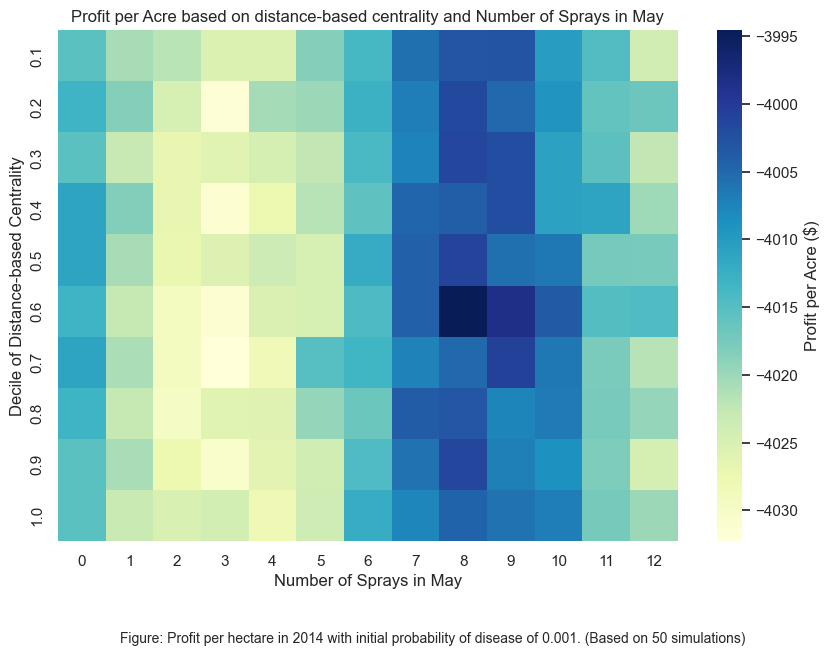

In [22]:
# Create a pivot table to get the mean profit for each combination of p_value and lambda_may
pivot_profit = df_profit_all.pivot_table(values='mean_profit', index='quartile', columns='lambda_may', aggfunc=np.mean)

# Plot the heatmap using Seaborn
sns.set_theme()
plt.figure(figsize=(10, 7))
ax = sns.heatmap(pivot_profit, cmap="YlGnBu", annot=False, fmt=".2f", cbar_kws={'label': 'Profit per Acre ($)'})
ax.set_title('Profit per Acre based on distance-based centrality and Number of Sprays in May')
ax.set_xlabel('Number of Sprays in May')
ax.set_ylabel('Decile of Distance-based Centrality')

plt.figtext(0.5, 0, f"Figure: Profit per hectare in {year} with initial probability of disease of {p_values[0]}. (Based on {simulations} simulations)", ha="center", fontsize=10, va="bottom")
plt.xticks(rotation=0)
plt.subplots_adjust(bottom=0.15)
plt.show()

In [47]:
df_profit_all

,quartile,mean_profit,lambda_may
0,0.1,-4015.372243,0
1,0.1,-4015.365826,0
2,0.1,-4015.381517,0
3,0.1,-4015.372446,0
4,0.1,-4015.377603,0
...,...,...,...
495,1.0,-4026.386119,12
496,1.0,-4025.516651,12
497,1.0,-4024.307881,12
498,1.0,-4020.411241,12


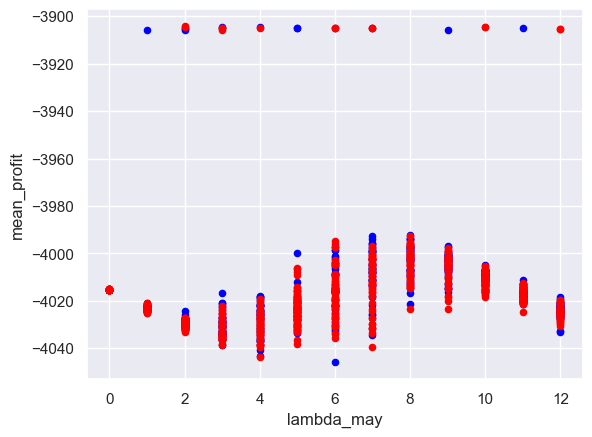

In [32]:
import matplotlib.pyplot as plt

df_profit_all.loc[df_profit_all['quartile'] == 0.1].plot(x='lambda_may', y='mean_profit', kind='scatter', color='blue', ax=plt.gca())
df_profit_all.loc[df_profit_all['quartile'] == 1].plot(x='lambda_may', y='mean_profit', kind='scatter', color='red', ax=plt.gca())
plt.show()

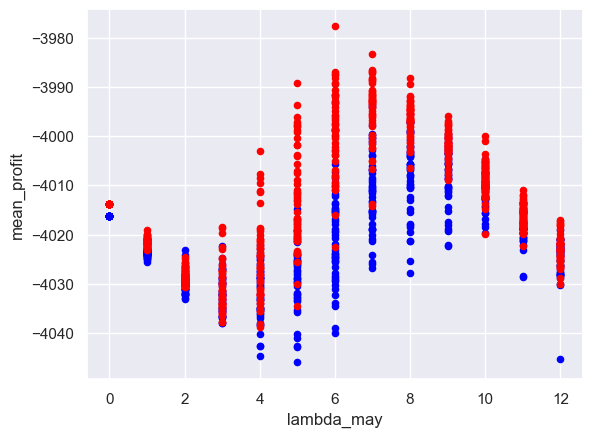

In [18]:
import matplotlib.pyplot as plt

df_profit_all.loc[df_profit_all['quartile'] == 0.1].plot(x='lambda_may', y='mean_profit', kind='scatter', color='blue', ax=plt.gca())
df_profit_all.loc[df_profit_all['quartile'] == 1].plot(x='lambda_may', y='mean_profit', kind='scatter', color='red', ax=plt.gca())
plt.show()


In [43]:
quartiles

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [21]:
centrality_decile

array([0.1, 0.1, 0.3, 0.2, 0.4, 0.7, 0.4, 0.4, 0.4, 0.2, 0.5, 0.4, 0.4,
       0.5, 0.6, 1. , 0.6, 0.3, 0.3, 0.2, 0.5, 0.5, 0.5, 0.9, 0.6, 0.5,
       0.5, 0.8, 0.5, 0.9, 0.8, 0.8, 0.3, 0.1, 0.2, 0.1, 0.2, 0.1, 0.3,
       0.3, 0.1, 0.1, 0.1, 0.2, 0.7, 0.8, 0.7, 0.3, 0.6, 0.7, 0.4, 0.2,
       0.1, 0.1, 0.4, 0.6, 0.6, 0.6, 0.4, 0.5, 0.3, 0.3, 0.3, 0.2, 0.4,
       1. , 0.9, 1. , 1. , 0.8, 0.6, 0.7, 0.7, 1. , 0.9, 1. , 0.8, 0.9,
       0.9, 0.5, 1. , 1. , 0.9, 0.2, 0.2, 0.7, 0.7, 0.7, 0.9, 0.9, 0.8,
       0.9, 1. , 0.6, 1. , 0.8, 0.8, 0.8, 0.7])

In [24]:
y_0_array.shape

(500, 99, 1)

## Heatmap

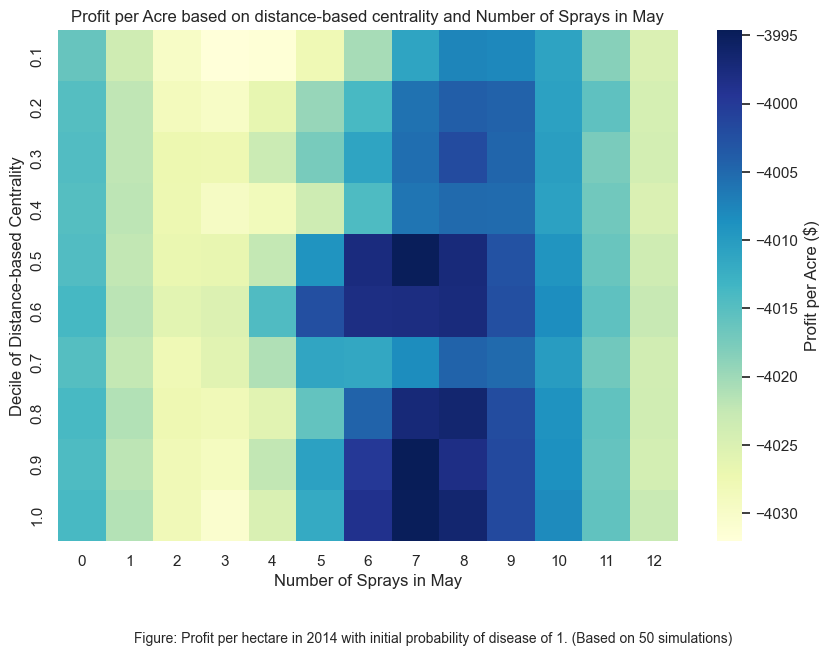

In [17]:
# Create a pivot table to get the mean profit for each combination of p_value and lambda_may
pivot_profit = df_profit_all.pivot_table(values='mean_profit', index='quartile', columns='lambda_may', aggfunc=np.mean)

# Plot the heatmap using Seaborn
sns.set_theme()
plt.figure(figsize=(10, 7))
ax = sns.heatmap(pivot_profit, cmap="YlGnBu", annot=False, fmt=".2f", cbar_kws={'label': 'Profit per Acre ($)'})
ax.set_title('Profit per Acre based on distance-based centrality and Number of Sprays in May')
ax.set_xlabel('Number of Sprays in May')
ax.set_ylabel('Decile of Distance-based Centrality')

plt.figtext(0.5, 0, f"Figure: Profit per hectare in {year} with initial probability of disease of {p_values[0]}. (Based on {simulations} simulations)", ha="center", fontsize=10, va="bottom")
plt.xticks(rotation=0)
plt.subplots_adjust(bottom=0.15)
plt.show()

In [49]:
import ipywidgets as widgets
from IPython.display import display

import pandas as pd
import networkx as nx
import numpy as np
import folium
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns  # Import seaborn


# Read data from CSV file into a pandas DataFrame
df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')

# Create a linear gradient colormap from blue to red

cmap = LinearSegmentedColormap.from_list('centrality_colormap', ['blue', 'yellow', 'red'], N=10)

cmap = LinearSegmentedColormap.from_list('approx_inferno', [
    '#FCFFA4',  # Yellow
    '#FCA50A', # Orange
    '#DD513A', # Red-orange
    '#932567', # Dark red
    '#420A68', # Purple
    '#000004' # Black
], N=10)

# Centroid Latitude and Longitude Coordinates
coord = df[(df['Year'] == 2014) & (df['Month'] == 'May')][['Centroid Lat', 'Centroid Long']].reset_index(drop=True)

# Initialize graph
G = nx.Graph()

# Add nodes with their coordinates
for index, row in coord.iterrows():
    G.add_node(index, pos=(row['Centroid Long'], row['Centroid Lat']))

def update_graph(alpha):

    G.remove_edges_from(list(G.edges()))

    # Add edges with weights using the new formula
    for i in G.nodes():
        for j in G.nodes():
            if i < j:  # This ensures that we don't calculate the distance twice
                area_i = area_apr[i]  # area of yard i
                wind_run_ij = ((w_may + w_jun) / 2)[i, j]  # average wind run from yard i to yard j over may and june
                distance_ij = distance[i, j]  # distance from yard i to yard j
                
                # Calculate edge weight using the provided formula
                weight = area_i * wind_run_ij * np.exp(-alpha*distance_ij)
                #weight = np.exp(-alpha*distance_ij)
                
                # Add edge with the calculated weight
                G.add_edge(i, j, weight=weight)

    # Centrality Statistics

    # Now calculate weighted degree centrality manually
    weighted_degree_centrality = {}
    for node in G.nodes():
        weighted_degree = sum(data['weight'] for _, _, data in G.edges(node, data=True))
        weighted_degree_centrality[node] = weighted_degree  # Make sure this is a scalar value


    # Convert centrality to DataFrame for easier manipulation
    degree_centrality_df = pd.DataFrame(list(weighted_degree_centrality.items()), columns=['Node', 'Centrality'])

    # Ensure 'Centrality' column has scalar values
    degree_centrality_df['Centrality'] = degree_centrality_df['Centrality'].apply(lambda x: x if np.isscalar(x) else x[0])

    # Convert centrality to deciles - this will create bins from 0.1 (10th percentile) to 1.0 (100th percentile)
    degree_centrality_df['Centrality_Decile'] = pd.qcut(degree_centrality_df['Centrality'], 10, labels=range(1, 11))

    # Since we've labeled the deciles 1 to 10, we need to normalize them to 0-1 for the colormap
    # This means 1 should become 0.1, and 10 should become 1.0, therefore we divide by 10
    degree_centrality_df['Centrality_Decile'] = degree_centrality_df['Centrality_Decile'].astype(int) / 10

    # Update the nodes with the centrality decile
    for row in degree_centrality_df.itertuples():
        G.nodes[row.Node]['centrality'] = row.Centrality
        # Normalize the centrality decile from 1-10 to 0.1-1.0 for colormap
        G.nodes[row.Node]['centrality_decile'] = row.Centrality_Decile

    # Initialize the map centered around the mean latitude and longitude of your nodes
    m = folium.Map(location=[coord['Centroid Lat'].mean(), coord['Centroid Long'].mean()], zoom_start=11)

    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')

    # Function to convert RGB to Hex
    def rgb_to_hex(rgb):
        return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

    # Get the colors for each node based on the centrality decile
    # Use matplotlib to get the RGB values, then convert to Hex
    node_colors = [rgb_to_hex(cmap(decile)) for decile in degree_centrality_df['Centrality_Decile']]

    # Add the nodes to the map using the hexadecimal color values
    for node, color in zip(G.nodes(), node_colors):
        pos_node = pos[node]
        folium.CircleMarker(
            location=(pos_node[1], pos_node[0]),  # Latitude and Longitude for Folium
            radius=5,  # Adjust size as needed
            color=color,  # Border color
            fill=True,
            fill_color=color,  # Fill color
            tooltip=f'Decile: {G.nodes[node]["centrality_decile"]:.1f}, Centrality: {G.nodes[node]["centrality"]:.4f}'  # Tooltip text
        ).add_to(m)

    
    # Show the map in the Jupyter Notebook
    display(m)
    
    
alpha_slider = widgets.FloatSlider(value=1.0, min=0.00001, max=3.0, step=0.001, description='Alpha:')
widgets.interactive(update_graph, alpha=alpha_slider)

interactive(children=(FloatSlider(value=1.0, description='Alpha:', max=3.0, min=1e-05, step=0.001), Output()),…